In [ ]:
!pip install nbimporter

In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import torch.nn.init as init
from torch.autograd import Variable
from dataLoader import loadData
from tensorflow import keras

In [2]:
# # Downloading Movielens-1m
# !curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip
# #     http://www.grouplens.org/system/files/ml-1m.zip
# !unzip ml-1m.zip
# !cd ml-1m/

In [3]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [4]:
seed = 47
np.random.seed(seed)

In [5]:
# load data
tr, vr = loadData('./ml-1m/ratings.dat', delimiter='::', seed=seed, transpose=False, valfrac=0.1)

reading data...
data read in 5.028218030929565 seconds
loaded dense data matrix


In [6]:
np.save('./tr_movielens_1m', tr)
np.save('./vr_movielens_1m', vr)

In [7]:
tr

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
vr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
def get_sparsity(mat):
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [10]:
get_sparsity(tr)

4.021525859265269

In [11]:
get_sparsity(vr)

0.44683670296601535

In [12]:
train = tr.copy()

In [13]:
if torch.cuda.is_available() == True:
    device = "cuda"
else:
    device = "cpu"

# Training Denoising Autoencoder

In [14]:
############## Pytorch model doesn't converge - to do - check #################

from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers

def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1', kernel_regularizer=regularizers.l2(0.000001))(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(512, activation='selu', name='LatentSpace', kernel_regularizer=regularizers.l2(0.000001))(enc)
    lat_space = Dropout(0.5, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1', kernel_regularizer=regularizers.l2(0.000001))(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred', kernel_regularizer=regularizers.l2(0.000001))(dec)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

Using TensorFlow backend.


In [15]:
zero_mask = (train == 0)
positive_feedback_mask = (train > 3)
negative_feedback_mask = ((train < 4) * (1 - zero_mask))

In [16]:
assert (positive_feedback_mask + negative_feedback_mask != zero_mask).all()
assert (positive_feedback_mask + negative_feedback_mask == 1 - zero_mask).all()

In [17]:
get_sparsity(zero_mask), get_sparsity(positive_feedback_mask), get_sparsity(negative_feedback_mask)

(95.97847414073473, 2.3124349989099473, 1.7090908603553212)

In [18]:
100 - get_sparsity(zero_mask), get_sparsity(positive_feedback_mask), get_sparsity(negative_feedback_mask), get_sparsity(positive_feedback_mask) + get_sparsity(negative_feedback_mask)

(4.021525859265267, 2.3124349989099473, 1.7090908603553212, 4.021525859265268)

In [19]:
P = 0.4
mask_arr_neg = (np.random.rand(negative_feedback_mask.shape[0], negative_feedback_mask.shape[1]) > P)
y_neg = negative_feedback_mask
X_neg = negative_feedback_mask*mask_arr_neg # corrupting 

In [20]:
mask_arr_pos = (np.random.rand(positive_feedback_mask.shape[0], positive_feedback_mask.shape[1]) > P)
y_pos = positive_feedback_mask
X_pos = positive_feedback_mask*mask_arr_pos # corrupting 

In [21]:
corrupted_tr = (mask_arr_neg*(tr>0)).astype(int)

In [22]:
get_sparsity(tr), get_sparsity(X_neg), get_sparsity(y_neg), get_sparsity(X_pos), get_sparsity(y_pos), get_sparsity(corrupted_tr)

(4.021525859265269,
 1.026195215919772,
 1.7090908603553212,
 1.3870741200058612,
 2.3124349989099473,
 2.4134703702247653)

In [23]:
model_neg = autoEncoder(X_neg)
model_neg.compile(optimizer = Adam(lr=0.0001), loss='mse')

model_pos = autoEncoder(X_pos)
model_pos.compile(optimizer = Adam(lr=0.0001), loss='mse')

In [24]:
model_neg = keras.models.load_model('./model_neg')
model_pos = keras.models.load_model('./model_pos')

In [25]:
model_neg.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       [(None, 3706)]            0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 512)               1897984   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               262656    
_________________________________________________________________
Dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 512)               262656    
_________________________________________________________________
UserScorePred (Dense)        (None, 3706)              1901178   
Total params: 4,324,474
Trainable params: 4,324,474
Non-trainable params: 0
_________________________________________________

In [ ]:
# predicted_tr = np.load('predicted_tr.npy')
# augmented_train = np.load('augmented_train.npy')

In [ ]:
hist_neg = model_neg.fit(x=X_neg, y=y_neg,
                  epochs=300,
                  batch_size=128,
                  shuffle=True,
# augmented_train = np.load('augmented_train.npy')
                  validation_split=0.0)

In [ ]:
hist_pos = model_pos.fit(x=X_pos, y=y_pos,
                  epochs=300,
                  batch_size=128,
                  shuffle=True,
                  validation_split=0.0)

In [ ]:
import matplotlib.pyplot as plt 

def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    #plt.plot(hist.history['val_loss'])

In [ ]:
plot_hist(hist_neg)

In [ ]:
plot_hist(hist_pos)

In [ ]:
model_neg.save('./model_neg')
model_pos.save('./model_pos')

In [26]:
np.set_printoptions(precision=3)
predicted_neg = model_neg.predict(X_neg)
predicted_pos = model_pos.predict(X_pos)

In [27]:
(predicted_neg > 0.4).sum(), (y_neg == 1).sum() # predicted vs real

(170143, 382567)

In [28]:
(predicted_neg>0.5).sum(), (predicted_pos>0.5).sum() # trained on

(115775, 214496)

In [29]:
print((y_neg * (predicted_neg>0.4)).sum()/(predicted_neg>0.4).sum()) # accuracy on actual 
print((y_pos * (predicted_pos>0.4)).sum()/(predicted_pos>0.4).sum())

0.9528337927508037
0.9187441580985445


In [30]:
print((y_pos * (predicted_neg>0.4)).sum()/(y_pos>0.4).sum()) # just to see that it's a low number
print((y_neg * (predicted_pos>0.4)).sum()/(y_neg>0.4).sum())

0.004936043939484681
0.016499070751005707


In [31]:
(y_neg * (predicted_neg>0.5)).sum()/((predicted_neg>0.5).sum())

0.9862405527963722

In [32]:
(y_pos * (predicted_pos>0.5)).sum()/((predicted_pos>0.5).sum())

0.9698642398925854

In [33]:
((predicted_neg>0.5)  * (X_neg<0.5)).sum() # predicted values which were not in the train matrix

39637

In [34]:
((predicted_pos>0.5)  * (X_pos<0.5)).sum() # predicted values which were not in the train matrix

69892

In [35]:
((y_neg * (((predicted_neg>0.5)  * (X_neg<0.5)))) == 1).sum()/(((predicted_neg>0.5)  * (X_neg<0.5))).sum()

0.9598102782753488

In [36]:
((y_pos * (((predicted_pos>0.5)  * (X_pos<0.5)))) == 1).sum()/(((predicted_pos>0.5)  * (X_pos<0.5))).sum()

0.9075144508670521

In [37]:
to_add_negative = model_neg.predict(y_neg)
to_add_positive = model_neg.predict(y_pos)

In [38]:
(to_add_negative>0.5).sum(), (to_add_positive>0.5).sum()

(207742, 234140)

In [39]:
(y_neg* (to_add_negative>0.8)).sum()/(((to_add_negative>0.8)).sum()), (y_pos* (to_add_positive>0.8)).sum()/(((to_add_positive>0.8)).sum())

(0.9874735206891682, 0.9078462031914041)

In [40]:
# to keep the balance
threshold_neg = 0.2
threshold_pos = 0.3 

In [41]:
((to_add_negative > threshold_neg) * (tr==0)).sum(), ((to_add_positive > threshold_pos) * (tr==0)).sum() # new values # new values

(345157, 240626)

In [42]:
p_probs_neg = [(tr == 1).sum()/((tr > 0) & (tr < 4)).sum(), (tr == 2).sum()/(((tr > 0) & (tr < 4))).sum(), (tr == 3).sum()/((tr > 0) & (tr < 4)).sum()]
p_probs_neg

[0.13207882540835983, 0.25313474502505445, 0.6147864295665857]

In [43]:
p_probs_pos = [(tr == 4).sum()/((tr > 3) & (tr <= 5)).sum(), (tr == 5).sum()/((tr > 3) & (tr <= 5)).sum()]
p_probs_pos

[0.6064147320143503, 0.39358526798564974]

In [44]:
augmented_train = tr + (to_add_negative > threshold_neg) * (tr == 0) * np.random.choice(np.arange(1, 4), tr.shape, p=p_probs_neg) + (to_add_positive > threshold_pos) * (tr == 0) * np.random.choice(np.arange(4, 6), tr.shape, p=p_probs_pos)

In [45]:
get_sparsity(tr), get_sparsity(augmented_train) # reduced sparsity

(4.021525859265269, 6.412851184583439)

In [46]:
(np.isin(tr, augmented_train)).all()

True

In [47]:
print(5, (5 == tr).sum())
print(4, (4 == tr).sum())
print(3, (3 == tr).sum())
print(2, (2 == tr).sum())
print(1, (1 == tr).sum())
print(0, (0 == tr).sum())

5 203728
4 313893
3 235197
2 96841
1 50529
0 21484052


In [48]:
print(5, (5 == augmented_train).sum())
print(4, (4 == augmented_train).sum())
print(3, (3 == augmented_train).sum())
print(2, (2 == augmented_train).sum())
print(1, (1 == augmented_train).sum())
print(0, (0 == augmented_train).sum())

5 282704
4 429003
3 416147
2 171461
1 89613
0 20948772


In [49]:
((tr == 0) * (augmented_train > 0)).sum() # new values

535280

In [50]:
# np.save('predicted_tr', predicted_tr)
np.save('augmented_train', augmented_train)

In [51]:
features_length = train.shape[1]
class NetD(torch.nn.Module):
    def __init__(self, feat_size):
        super(NetD, self).__init__()
        self.feat_size = feat_size
#         self.use_cuda = True
#         self.feat_size = feat_size
        # top
#         print(self.feat_size*2)
        self.t1 = torch.nn.Linear(self.feat_size, 1024)
        # bottom
        self.b1 = torch.nn.Linear(self.feat_size, 1024)
        # combined
        self.fc = torch.nn.Linear(2 * 1024, self.feat_size)
    def forward(self, xr, xf):
        # get filt
        
        filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
#         if self.use_cuda: 
        idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = F.tanh(self.fc(x))
        # apply filter, aggregate
        x = filt * x
        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x


class NetG(nn.Module):
    
    def __init__(self, feat_size):

        super(NetG, self).__init__()
        self.feat_size = feat_size
        self.netGen = torch.nn.Sequential( 
                                torch.nn.Linear(nz + self.feat_size, 1024), 
#                                 torch.nn.BatchNorm1d(1024),
                                torch.nn.ReLU(), 
#                                 nn.Dropout(0.5),
#                                 torch.nn.Linear(1024, 1024),
# #                                 torch.nn.BatchNorm1d(1024),
#                                 torch.nn.ReLU(), 
#                                 nn.Dropout(0.6),
                                torch.nn.Linear(1024, features_length), 
                                torch.nn.Sigmoid()
#                                 torch.nn.BatchNorm1d(features_length),
#                                 nn.Dropout(0.7),
#                                 torch.nn.Sigmoid()
                                )

        
    def forward(self, e_mask, x):
        x = self.netGen(x)
        x = x * e_mask
        return x
#         return F.dropout(x, 0.7)
#         return 5 * self.netGen(x)
#         return torch.sigmoid(x) 
#         return x*5 # to get values in range [0,5]

In [52]:
def get_random_batch(mat, batch_size=64):
    '''
    returns random rows of size batch_size
    '''
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(mat.shape, rand_rows)
#     print(mat[rand_rows].shape)
    return mat[rand_rows]

In [53]:
train = torch.autograd.Variable(torch.Tensor(train))
augmented_train = torch.autograd.Variable(torch.Tensor(augmented_train))

In [57]:
del train
del augmented_train

In [54]:
get_sparsity(train.cpu().numpy()), get_sparsity(augmented_train.cpu().numpy())

(4.021525859265269, 6.412851184583439)

In [55]:
# xx = get_random_batch(train)
# xy = get_random_batch(train)

In [56]:
# d_my(xx, xy)

In [ ]:
# torch.sum(torch.abs(torch.abs(xx != 0).float()*xy - xy), 1)

In [ ]:
# xx > xy

In [ ]:
# # def d_my(x_r, x_g): # custom loss -todo
# #     return torch.sum(torch.abs((x_r != 0).float() * x_g - x_r), 1)/x_r.shape[1]

# def d_my(x_r, x_g): # custom loss -todo
#     return torch.sum(torch.abs(x_g - x_r), 1)/x_r.shape[1]

In [92]:
def batch_generator(corrupted, original, batch_size=64):
    rand_rows = np.random.randint(corrupted.shape[0], size=batch_size)
    return torch.Tensor(corrupted[rand_rows]).cuda().float(), torch.Tensor(original[rand_rows]).cuda().float(), rand_rows
#     return torch.from_numpy(corrupted[rand_rows]).float(), torch.from_numpy(original[rand_rows]).float()

In [93]:
get_sparsity(X_neg), get_sparsity(y_neg)

(1.026195215919772, 1.7090908603553212)

In [94]:
a,b,_ = batch_generator(X_neg, (tr > 0).astype(float))

get_sparsity(a.cpu().numpy()), get_sparsity(b.cpu().numpy()), a.shape, b.shape

(1.1033627900701564,
 4.1528939557474365,
 torch.Size([64, 3706]),
 torch.Size([64, 3706]))

In [266]:
gen_losses = []
disc_losses = []
def train_GAN(netD, netG, negative, steps_per_epoch = 100, epochs = 100):
    d_iter = 5
    g_iter = 1
    gen_iterations = 0
#     gen_losses = []
#     disc_losses = []
#     train_losses = []
    for epoch in range(epochs):
        for c in range(steps_per_epoch):
            data_iter = 100
            i = 0
            while i < 100:
                ############################
                # (1) Update D network
                ###########################
                for p in netD.parameters(): # reset requires_grad
                    p.requires_grad = True # they are set to False below in netG update
    #             d_iter = d_iter
                j = 0
                while j < d_iter*5:
                    j += 1
                    # load real data
                    i += 1
                    if negative:
                        condition, X, idxs = batch_generator(X_neg, y_neg)
    #                 X, _ = data_iter.next()
    #                 X = X.view(X.size(0), -1)
    #                 X = (X >= 0.5).float()
#                     if cuda: 
                    X = X.cuda()
                    condition = condition.cuda()
    #                 print(condition.shape, X_neg.shape, y_neg.shape)
                    real = Variable(X)

                    # generate fake data
                    noise = torch.randn(batch_size, nz)
#                     if cuda: 
                    noise = noise.cuda()
                    noisev = Variable(noise, volatile = True) # totally freeze netG
                    concated = torch.cat((noisev, condition), 1)
    #                 print(condition.shape, condition.shape, X.shape, noisev.shape, )
                    e_mask = torch.Tensor(tr[idxs]>0).cuda()
                    fake = Variable(netG(e_mask, concated).data)

                    # compute gradient, take step
                    netD.zero_grad()
    #                 concated_real = torch.cat((real, condition), 1)
    #                 print(concated_real)
                    out = netD(real, fake)
                    outputD = torch.mean(out) + lamba * out.norm()
                    stdD = torch.std(out)
                    outputD.backward(mone)
                    optimizerD.step()
#                     print('AAAAAAAAA mse:=WWWWWWWWWWWWWWWWWWWWWW')
            ############################
            # (2) Update G network
            ###########################

    #         g_iter = g_iter
            j = 0
            while j < g_iter*5:
                j += 1
                for p in netD.parameters():
                    p.requires_grad = False # to avoid computation
                netG.zero_grad()
                # load real data

                i += 1

                if negative:
                    condition, X, idxs = batch_generator(X_neg, y_neg)
                    
                X = X.cuda()
                condition = condition.cuda()
                real = Variable(X)

                # update generator
                noise = torch.randn(batch_size, nz)
                noise = noise.cuda()
                noisev = Variable(noise)
                concated_ = torch.cat((noisev, condition), 1)
                e_mask_ = torch.Tensor(tr[idxs]>0).cuda()
 
                fake = netG(e_mask_, concated_)
                out = netD(real, fake)
                outputG = torch.mean(out) + lamba * out.norm()
                stdG = torch.std(out)
                outputG.backward(one)
                optimizerG.step()
                gen_iterations += 1
#             print('AAAAAA')
            eval_loss = F.mse_loss(fake, real, reduction='mean')
#             eval_losses.append(eval_loss)
#             print('mse:', eval_loss)
#             print(outputG.item(), outputD.item())
            gen_losses.append(outputG.item())
            disc_losses.append(outputD.item())
            print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, 100, gen_iterations, outputD.item(), outputG.item()))
    return gen_losses, disc_losses

In [267]:
get_sparsity(X_neg), get_sparsity(y_neg)

(1.026195215919772, 1.7090908603553212)

In [272]:
# lrD = 5e-4
# lrG = 5e-4
# batch_size = 128
# cuda = True
# epochs = 1000 #change
# seed = 1
# nz = 16
# d_iter = 5
# g_iter = 1
# lamba = 2e-4

lrD = 1e-4
lrG = 1e-4
batch_size = 64
cuda = True
epochs = 1000
device = 5
seed = 1
nz = 20
lamba = 1e-4 
# lamba = 0

In [273]:
negative_feedback_mask.shape[1]

3706

In [274]:
# networks
netD_neg = NetD(negative_feedback_mask.shape[1]).cuda()
netG_neg = NetG(negative_feedback_mask.shape[1]).cuda()
print(netD_neg)
print(netG_neg)
optimizerG = optim.Adam(netG_neg.parameters(), lr=lrG, weight_decay=1e-5)
optimizerD = optim.Adam(netD_neg.parameters(), lr=lrD, weight_decay=1e-5)
one = torch.FloatTensor([1]).cuda()
mone = (-1 * one).cuda()

NetD(
  (t1): Linear(in_features=3706, out_features=1024, bias=True)
  (b1): Linear(in_features=3706, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=3706, bias=True)
)
NetG(
  (netGen): Sequential(
    (0): Linear(in_features=3726, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=3706, bias=True)
    (3): Sigmoid()
  )
)


In [275]:
netD_neg.train()
netG_neg.train()
# gen_losses, disc_losses = train_GAN(netD_neg, netG_neg, negative=True)
train_GAN(netD_neg, netG_neg, negative=True)

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\Users\David\Anaconda3\lib\site-packages\torch\nn\functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[0/100][105/100][5] Loss_D: 0.004765 Loss_G: 0.005677 
[0/100][105/100][10] Loss_D: 0.011974 Loss_G: 0.013254 
[0/100][105/100][15] Loss_D: 0.015144 Loss_G: 0.014056 
[0/100][105/100][20] Loss_D: 0.012693 Loss_G: 0.013647 
[0/100][105/100][25] Loss_D: 0.010267 Loss_G: 0.011395 
[0/100][105/100][30] Loss_D: 0.015602 Loss_G: 0.014241 
[0/100][105/100][35] Loss_D: 0.014503 Loss_G: 0.011896 
[0/100][105/100][40] Loss_D: 0.016728 Loss_G: 0.007080 
[0/100][105/100][45] Loss_D: 0.010229 Loss_G: 0.008234 
[0/100][105/100][50] Loss_D: 0.010473 Loss_G: 0.012013 
[0/100][105/100][55] Loss_D: 0.012195 Loss_G: 0.007282 
[0/100][105/100][60] Loss_D: 0.007312 Loss_G: 0.004856 
[0/100][105/100][65] Loss_D: 0.005318 Loss_G: 0.005430 
[0/100][105/100][70] Loss_D: 0.010276 Loss_G: 0.004839 
[0/100][105/100][75] Loss_D: 0.008518 Loss_G: 0.006709 
[0/100][105/100][80] Loss_D: 0.005113 Loss_G: 0.010600 
[0/100][105/100][85] Loss_D: 0.003609 Loss_G: 0.006810 
[0/100][105/100][90] Loss_D: 0.009268 Loss_G: 0.0

[1/100][105/100][725] Loss_D: 0.003820 Loss_G: 0.003263 
[1/100][105/100][730] Loss_D: 0.005123 Loss_G: 0.003017 
[1/100][105/100][735] Loss_D: 0.002285 Loss_G: 0.004440 
[1/100][105/100][740] Loss_D: 0.007313 Loss_G: 0.004237 
[1/100][105/100][745] Loss_D: 0.004081 Loss_G: 0.002286 
[1/100][105/100][750] Loss_D: 0.005370 Loss_G: 0.003664 
[1/100][105/100][755] Loss_D: 0.004580 Loss_G: 0.003621 
[1/100][105/100][760] Loss_D: 0.004311 Loss_G: 0.003937 
[1/100][105/100][765] Loss_D: 0.007531 Loss_G: 0.006046 
[1/100][105/100][770] Loss_D: 0.004024 Loss_G: 0.005351 
[1/100][105/100][775] Loss_D: 0.005362 Loss_G: 0.003614 
[1/100][105/100][780] Loss_D: 0.003904 Loss_G: 0.004471 
[1/100][105/100][785] Loss_D: 0.005751 Loss_G: 0.003906 
[1/100][105/100][790] Loss_D: 0.005085 Loss_G: 0.003947 
[1/100][105/100][795] Loss_D: 0.003909 Loss_G: 0.004857 
[1/100][105/100][800] Loss_D: 0.003367 Loss_G: 0.003488 
[1/100][105/100][805] Loss_D: 0.002750 Loss_G: 0.006251 
[1/100][105/100][810] Loss_D: 0

[2/100][105/100][1435] Loss_D: 0.004806 Loss_G: 0.008301 
[2/100][105/100][1440] Loss_D: 0.007686 Loss_G: 0.004062 
[2/100][105/100][1445] Loss_D: 0.004203 Loss_G: 0.003995 
[2/100][105/100][1450] Loss_D: 0.006330 Loss_G: 0.006498 
[2/100][105/100][1455] Loss_D: 0.005980 Loss_G: 0.006398 
[2/100][105/100][1460] Loss_D: 0.007376 Loss_G: 0.005464 
[2/100][105/100][1465] Loss_D: 0.006165 Loss_G: 0.006619 
[2/100][105/100][1470] Loss_D: 0.007495 Loss_G: 0.007382 
[2/100][105/100][1475] Loss_D: 0.005264 Loss_G: 0.008153 
[2/100][105/100][1480] Loss_D: 0.007551 Loss_G: 0.005735 
[2/100][105/100][1485] Loss_D: 0.007449 Loss_G: 0.007875 
[2/100][105/100][1490] Loss_D: 0.007589 Loss_G: 0.003581 
[2/100][105/100][1495] Loss_D: 0.005790 Loss_G: 0.004218 
[2/100][105/100][1500] Loss_D: 0.006050 Loss_G: 0.004989 
[3/100][105/100][1505] Loss_D: 0.004186 Loss_G: 0.005205 
[3/100][105/100][1510] Loss_D: 0.002844 Loss_G: 0.003980 
[3/100][105/100][1515] Loss_D: 0.008137 Loss_G: 0.005705 
[3/100][105/10

[4/100][105/100][2140] Loss_D: 0.005397 Loss_G: 0.008067 
[4/100][105/100][2145] Loss_D: 0.006114 Loss_G: 0.006646 
[4/100][105/100][2150] Loss_D: 0.002982 Loss_G: 0.006516 
[4/100][105/100][2155] Loss_D: 0.003202 Loss_G: 0.003983 
[4/100][105/100][2160] Loss_D: 0.004661 Loss_G: 0.005527 
[4/100][105/100][2165] Loss_D: 0.009507 Loss_G: 0.006536 
[4/100][105/100][2170] Loss_D: 0.009770 Loss_G: 0.005267 
[4/100][105/100][2175] Loss_D: 0.009493 Loss_G: 0.006496 
[4/100][105/100][2180] Loss_D: 0.008079 Loss_G: 0.005069 
[4/100][105/100][2185] Loss_D: 0.006594 Loss_G: 0.005928 
[4/100][105/100][2190] Loss_D: 0.005231 Loss_G: 0.005411 
[4/100][105/100][2195] Loss_D: 0.006604 Loss_G: 0.007546 
[4/100][105/100][2200] Loss_D: 0.005046 Loss_G: 0.005359 
[4/100][105/100][2205] Loss_D: 0.007615 Loss_G: 0.005027 
[4/100][105/100][2210] Loss_D: 0.005627 Loss_G: 0.006062 
[4/100][105/100][2215] Loss_D: 0.007993 Loss_G: 0.006666 
[4/100][105/100][2220] Loss_D: 0.006909 Loss_G: 0.005164 
[4/100][105/10

[5/100][105/100][2845] Loss_D: 0.004119 Loss_G: 0.004469 
[5/100][105/100][2850] Loss_D: 0.005417 Loss_G: 0.004402 
[5/100][105/100][2855] Loss_D: 0.007087 Loss_G: 0.004485 
[5/100][105/100][2860] Loss_D: 0.009024 Loss_G: 0.007040 
[5/100][105/100][2865] Loss_D: 0.008499 Loss_G: 0.004693 
[5/100][105/100][2870] Loss_D: 0.008288 Loss_G: 0.009006 
[5/100][105/100][2875] Loss_D: 0.006770 Loss_G: 0.005942 
[5/100][105/100][2880] Loss_D: 0.006273 Loss_G: 0.005287 
[5/100][105/100][2885] Loss_D: 0.004838 Loss_G: 0.003887 
[5/100][105/100][2890] Loss_D: 0.003881 Loss_G: 0.003454 
[5/100][105/100][2895] Loss_D: 0.004680 Loss_G: 0.005334 
[5/100][105/100][2900] Loss_D: 0.005735 Loss_G: 0.005706 
[5/100][105/100][2905] Loss_D: 0.005310 Loss_G: 0.006628 
[5/100][105/100][2910] Loss_D: 0.004858 Loss_G: 0.006431 
[5/100][105/100][2915] Loss_D: 0.004043 Loss_G: 0.006606 
[5/100][105/100][2920] Loss_D: 0.008372 Loss_G: 0.007513 
[5/100][105/100][2925] Loss_D: 0.006713 Loss_G: 0.008142 
[5/100][105/10

[7/100][105/100][3550] Loss_D: 0.006843 Loss_G: 0.006590 
[7/100][105/100][3555] Loss_D: 0.010885 Loss_G: 0.008217 
[7/100][105/100][3560] Loss_D: 0.007823 Loss_G: 0.005529 
[7/100][105/100][3565] Loss_D: 0.006486 Loss_G: 0.006630 
[7/100][105/100][3570] Loss_D: 0.004492 Loss_G: 0.006928 
[7/100][105/100][3575] Loss_D: 0.004888 Loss_G: 0.004890 
[7/100][105/100][3580] Loss_D: 0.003998 Loss_G: 0.004077 
[7/100][105/100][3585] Loss_D: 0.005253 Loss_G: 0.004575 
[7/100][105/100][3590] Loss_D: 0.006821 Loss_G: 0.007693 
[7/100][105/100][3595] Loss_D: 0.007880 Loss_G: 0.004962 
[7/100][105/100][3600] Loss_D: 0.004799 Loss_G: 0.005597 
[7/100][105/100][3605] Loss_D: 0.010919 Loss_G: 0.007115 
[7/100][105/100][3610] Loss_D: 0.007371 Loss_G: 0.009385 
[7/100][105/100][3615] Loss_D: 0.003818 Loss_G: 0.006177 
[7/100][105/100][3620] Loss_D: 0.005859 Loss_G: 0.006213 
[7/100][105/100][3625] Loss_D: 0.006285 Loss_G: 0.005348 
[7/100][105/100][3630] Loss_D: 0.003143 Loss_G: 0.003901 
[7/100][105/10

KeyboardInterrupt: 

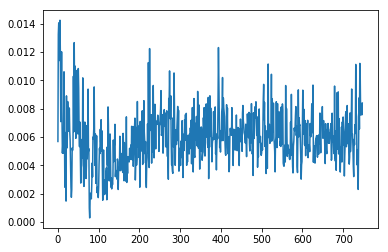

In [276]:
import matplotlib.pyplot as plt

plt.plot(gen_losses)
plt.show()

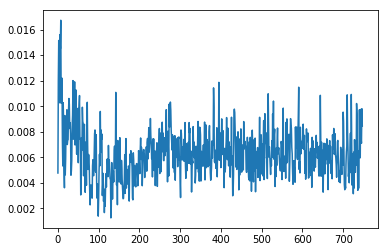

In [277]:
plt.plot(disc_losses)
plt.show()

In [278]:
torch.save(netD_neg.state_dict(), './netD_neg-1m')
torch.save(netG_neg.state_dict(), './netG_neg-1m')

In [279]:
netD_neg.eval()

NetD(
  (t1): Linear(in_features=3706, out_features=1024, bias=True)
  (b1): Linear(in_features=3706, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=3706, bias=True)
)

In [280]:
import gc
gc.collect()

7561

In [281]:
# networks
netD_neg_test = NetD(negative_feedback_mask.shape[1]).cuda()
netG_neg_test = NetG(negative_feedback_mask.shape[1]).cuda()

netD_neg_test.eval()
netG_neg_test.eval()

NetG(
  (netGen): Sequential(
    (0): Linear(in_features=3726, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=3706, bias=True)
    (3): Sigmoid()
  )
)

In [346]:
condition, X, idxs = batch_generator(X_neg, y_neg, batch_size=256)

X = X.cuda()
condition = condition.cuda()
# real = Variable(X)

noise = torch.randn(256, nz).cuda()
e_mask = torch.Tensor(tr[idxs]>0).cuda()

concated = torch.cat((noise, condition), 1)
fake = netG_neg(e_mask, concated)

In [353]:
fake_test = netG_neg_test(e_mask, concated)

In [354]:
(fake >= 0.5).sum(), ((fake >= 0.5) * (condition==0)).sum(), condition.sum(), X.sum(), e_mask.sum()

(tensor(14022, device='cuda:0'),
 tensor(8502, device='cuda:0'),
 tensor(10039., device='cuda:0'),
 tensor(16809., device='cuda:0'),
 tensor(38566., device='cuda:0'))

In [384]:
fake = (fake > 0.5).float()

In [389]:
fake_test = (fake_test > 0.5).float()

In [385]:
(fake * condition).sum()/condition.sum(), (fake * X).sum()/X.sum()

(tensor(0.5498, device='cuda:0'), tensor(0.5527, device='cuda:0'))

In [390]:
(fake_test * condition).sum()/condition.sum(), (fake_test * X).sum()/X.sum()

(tensor(0.4833, device='cuda:0'), tensor(0.4881, device='cuda:0'))

In [413]:
# accuraccy on zeros (positive feedbacks)
(fake * (1-condition)*X).sum()/(X * (1 - condition)).sum()

tensor(0.5572, device='cuda:0')

In [398]:
(fake_test * (1-condition)*X).sum()/(X * (1 - condition)).sum()

tensor(0.4953, device='cuda:0')

In [439]:
# accuraccy on zeros (positive feedbacks)
((1 - fake)*(1-condition)*(torch.from_numpy(positive_feedback_mask[idxs]).float().cuda())).cpu().numpy().sum()/((positive_feedback_mask[idxs]).astype(float)*(1-condition).cpu().numpy()).sum()

0.7825987038654226

In [428]:
(X == torch.from_numpy(negative_feedback_mask[idxs]).float().cuda()).all()

tensor(1, device='cuda:0', dtype=torch.uint8)

In [434]:
((1 - fake_test)*(1-condition)*(torch.from_numpy(positive_feedback_mask[idxs]).float().cuda())).cpu().numpy().sum()/((positive_feedback_mask[idxs]).astype(float)*(1-condition).cpu().numpy()).sum()

0.519327113113021

In [355]:
(fake_test >= 0.5).sum(), ((fake_test >= 0.5) * (condition==0)).sum(), condition.sum(), X.sum()

(tensor(18663, device='cuda:0'),
 tensor(13811, device='cuda:0'),
 tensor(10039., device='cuda:0'),
 tensor(16809., device='cuda:0'))

In [356]:
(fake >= 0.5).sum(), ((fake >= 0.5) * (condition==0)).sum(), condition.sum(), X.sum()

(tensor(14022, device='cuda:0'),
 tensor(8502, device='cuda:0'),
 tensor(10039., device='cuda:0'),
 tensor(16809., device='cuda:0'))

In [357]:
(fake > 0.5).sum()

tensor(14021, device='cuda:0')

In [358]:
(fake_test > 0.5).sum()

tensor(18663, device='cuda:0')

In [290]:
X.shape

torch.Size([256, 3706])

In [291]:
(fake > 0.48).sum(), ((fake > 0.48) * (condition==0)).sum(), condition.sum()

(tensor(34164, device='cuda:0'),
 tensor(24892, device='cuda:0'),
 tensor(10422., device='cuda:0'))

In [292]:
e_mask = torch.Tensor(tr[idxs]).cuda()

In [293]:
np.isin(condition.cpu().numpy(), X.cpu().numpy()).all()

True

In [294]:
(fake > 0.4).float().sum()

tensor(35208., device='cuda:0')

In [295]:
((fake > 0.4).float() * (condition==0).float() * X).sum(), 

(tensor(6323., device='cuda:0'),)

In [296]:
((fake > 0.5).float() * (condition==0).float()).sum()

tensor(24702., device='cuda:0')

In [298]:
((fake > 0.5).float()).sum()/X.sum() # predicted accuraccy

tensor(1.9492, device='cuda:0')

In [299]:
(fake > 0.5).sum()

tensor(33895, device='cuda:0')

In [300]:
((fake > 0.5).float() *(condition==0).float()* X).sum()

tensor(6068., device='cuda:0')

In [368]:
((fake > 0.5).float() *(condition==0).float()* X).sum()/((fake > 0.5) * (condition==0)).sum() # predicted accuraccy

tensor(0.4437, device='cuda:0')

In [370]:
((fake_test > 0.5).float() *(condition==0).float()* X).sum()/((fake_test > 0.5) * (condition==0)).sum() # predicted accuraccy

tensor(0.2428, device='cuda:0')

In [369]:
((fake > 0.5).float() * (condition==0).float()).sum()/(X * (1 - condition)).sum() # predicted accuraccy

tensor(1.2558, device='cuda:0')

In [306]:
((fake > 0.5).float() * (condition==0).float()).sum()/(X * (1 - condition)).sum() # predicted accuraccy

tensor(3.5456, device='cuda:0')

In [307]:
((fake > 0.5).float()).sum()/((condition)).sum() # predicted accuraccy

tensor(3.2523, device='cuda:0')

In [308]:
((fake > 0.5).float()).sum()/((condition)).sum() # predicted accuraccy

tensor(3.2523, device='cuda:0')

In [309]:
((fake_test > 0.5).float() * (condition==0).float() * X).sum()/(X * (1 - condition)).sum() # predicted accuraccy

tensor(0.4956, device='cuda:0')

In [310]:
((fake > 0.5).float() ).sum()/X.sum() # whole accuraccy

tensor(1.9492, device='cuda:0')

In [311]:
((fake_test > 0.5).float() ).sum()/X.sum() # whole accuraccy

tensor(0.4893, device='cuda:0')

In [382]:
# ((fake > 0.5).float() * (condition==0).float() * X).sum()/(X * (1 - fake)).sum()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(eval_losses_tr)
plt.show()

In [ ]:
# noise = torch.randn(train.shape[0], nz).to(device)
# noisev = Variable(noise)
# fake = netG_tr(noisev)

In [ ]:
fake.shape

In [ ]:
fake = np.around(fake.detach().cpu().numpy())

In [ ]:
np.unique(fake)

In [ ]:
fake = fake * (fake <= 5).astype(int)

In [ ]:
np.unique(fake)

In [ ]:
get_sparsity(fake)

In [ ]:
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

As we see there is a significant bias towards higher ratings

In [ ]:
# networks
netD_augm = NetD().to(device)
netG_augm = NetG().to(device)
print(netD_augm)
print(netG_augm)
optimizerG = optim.RMSprop(netG_augm.parameters(), lr=lrG)
optimizerD = optim.RMSprop(netD_augm.parameters(), lr=lrD)
one = torch.FloatTensor([1]).to(device)
mone = (-1 * one).to(device)

In [ ]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)
fake = netG_augm(noisev)

In [ ]:
fake = np.around(fake.detach().cpu().numpy())
np.unique(fake)

In [ ]:
# without train
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

In [ ]:
# netD_augm.load_state_dict(torch.load('./netG_augm-1m'))
# netD_augm.load_state_dict(torch.load('./netD_augm-1m'))

In [ ]:
netD_augm.train()
netG_augm.train()
eval_losses_aug = train_GAN(netD_augm, netG_augm, augmented_train)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(eval_losses_aug)
plt.show()

In [ ]:
# netG_tr.eval()
netG_augm.eval()

In [ ]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)
fake = netG_augm(noisev)

In [ ]:
fake = np.around(fake.detach().cpu().numpy())

In [ ]:
np.unique(fake)

In [ ]:
# fake = fake * (fake <= 5).astype(int)

fake = fake.clip(0,5)

In [ ]:
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

In [ ]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)

fake_tr = netG_tr(noisev)
fake_aug = netG_augm(noisev)

In [ ]:
torch.unique(fake_tr.round()), torch.unique(fake_aug.round())

In [ ]:
fake_tr = fake_tr.clamp(0,5).detach().cpu().numpy().round()
fake_aug = fake_aug.clamp(0,5).detach().cpu().numpy().round()

In [ ]:
print(5, (5 == fake_tr).sum(), (5 == (tr + vr)[:fake.shape[0], :]).sum())
print(4, (4 == fake_tr).sum(), (4 == (tr + vr)[:fake.shape[0], :]).sum())
print(3, (3 == fake_tr).sum(), (3 == (tr + vr)[:fake.shape[0], :]).sum())
print(2, (2 == fake_tr).sum(), (2 == (tr + vr)[:fake.shape[0], :]).sum())
print(1, (1 == fake_tr).sum(), (1 == (tr + vr)[:fake.shape[0], :]).sum())
print(0, (0 == fake_tr).sum(), (0 == (tr + vr)[:fake.shape[0], :]).sum())

In [ ]:
print(5, (5 == fake_aug).sum(), (5 == (tr + vr)[:fake.shape[0], :]).sum())
print(4, (4 == fake_aug).sum(), (4 == (tr + vr)[:fake.shape[0], :]).sum())
print(3, (3 == fake_aug).sum(), (3 == (tr + vr)[:fake.shape[0], :]).sum())
print(2, (2 == fake_aug).sum(), (2 == (tr + vr)[:fake.shape[0], :]).sum())
print(1, (1 == fake_aug).sum(), (1 == (tr + vr)[:fake.shape[0], :]).sum())
print(0, (0 == fake_aug).sum(), (0 == (tr + vr)[:fake.shape[0], :]).sum())

In [ ]:
get_sparsity(tr), get_sparsity(fake_tr), get_sparsity(fake_aug)

In [ ]:
# tr_orig, vr_1 = loadData('./ml-1m/ratings.dat', delimiter='::', seed=seed,  transpose=False, valfrac=0.1)

In [ ]:
import nbimporter 
import matrix_factorization

In [ ]:
rand_ix = np.random.randint(0, fake.shape[0], 300)

In [ ]:
# adding_fake_autoenc = fake_tr[rand_ix,:]
adding_fake_autoenc_lus_gan = fake_aug[rand_ix,:]

In [ ]:
np.unique(fake_aug)

In [ ]:
np.unique(adding_fake_autoenc_lus_gan[0,:])

In [ ]:
(adding_fake_autoenc == 1).sum()

In [ ]:
(adding_fake_autoenc_lus_gan == 1).sum()

In [ ]:
np.unique(adding_fake_autoenc_lus_gan[0,:])

In [ ]:
adding_fake[0,0:200]

In [ ]:
adding_fake_autoenc_lus_gan[0,0:200]

In [ ]:
tr_auto_enc = np.append(tr, adding_fake_autoenc, axis=0)
tr_auto_enc_plus_gan = np.append(tr, adding_fake_autoenc_lus_gan, axis=0)

In [ ]:
iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([60], vr, learning_rate=0.001)

In [ ]:
get_sparsity(augmented_train.cpu().numpy())

In [ ]:
# iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(augmented_train.cpu().numpy(), 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([60], vr, learning_rate=0.001)

In [ ]:
# iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([50], vr, learning_rate=0.001)

In [ ]:
# iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(augmented_train.cpu().numpy(), 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([50], vr, learning_rate=0.001)

In [ ]:
tr.shape, augmented_train.cpu().numpy().shape, tr_auto_enc.shape, tr_auto_enc_plus_gan.shape

In [ ]:
get_sparsity(tr_auto_enc), get_sparsity(tr_auto_enc_plus_gan)

In [ ]:
# iter_array = [1, 2, 5, 10, 25, 40]

MF_SGD = matrix_factorization.ExplicitMF(tr_auto_enc, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
# iter_array = [1, 2, 5, 10, 25, 40]

MF_SGD = matrix_factorization.ExplicitMF(tr_auto_enc_plus_gan, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([60], vr, learning_rate=0.001)

In [ ]:
get_sparsity(tr_auto_enc_plus_gan), tr_auto_enc_plus_gan.shape

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(tr_auto_enc_plus_gan, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([60], vr, learning_rate=0.001)

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(tr_auto_enc_plus_gan, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([60], vr, learning_rate=0.001)

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(fake_aug, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 60]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
augmented_tr = augmented_train.cpu().numpy()

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(augmented_tr, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 60]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 60]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='als', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 60]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(augmented_tr, 40, learning='als', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 60]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)